In [2]:
import numpy as np
import scipy as sp
import sys

sys.version

stats.multivariate_normal.pdf(

data log-likelihood for parameter initializations:
-76304.7202927
data log-likelihood for fitted parameters:
-64428.0630338
elapsed time for fitting is
1220.599112033844


/home/mackelab/anaconda/envs/py3k/lib/python3.3/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


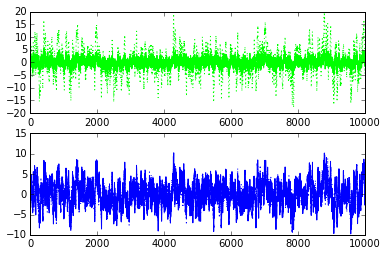

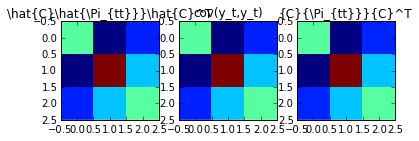

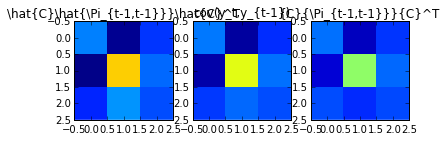

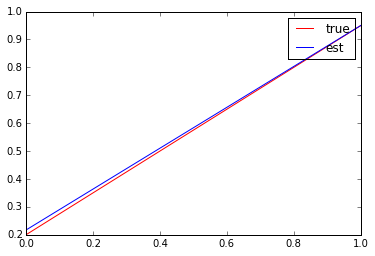

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import time

import ssm_timeSeries as ts  # my self-written time series overhead

from IPython import display  # for live plotting

import random
from datetime import datetime     # generate random seed for 
random.seed(datetime.now())       # np.random. Once this is fixed, all 
rngSeed = random.randint(0, 1000) # other 'randomness' is also fixed

from scipy.io import savemat # store results for comparison with Matlab code

xDim = 2
yDim = 3
while True:
    W    = np.random.normal(size=[xDim,xDim])
    if np.abs(np.linalg.det(W)) > 0.001:
        break
A    = np.diag(np.linspace(0.2,0.95,xDim))  #np.diag(np.random.uniform(size=[xDim]))
A    = np.dot(np.dot(W, A), np.linalg.inv(W))
Q    = np.identity(xDim)
mu0  = np.ones(xDim) #np.random.normal(size=[xDim])
V0   = np.identity(xDim)
C = np.random.normal(size=[yDim, xDim])
R = 3 * np.identity(yDim)

T = 10000
seq = ts.setStateSpaceModel('LDS', [xDim,yDim], [A,Q,mu0,V0,C,R])  # initiate true model
seq.giveEmpirical().addData(1,T,rngSeed)                           # draw toy data

# initiate parameters for analysis model
A_0   = np.diag(np.random.uniform(size=[xDim])) #A
Q_0   = 10*np.identity(xDim)               #Q
mu0_0 = 5*np.random.normal(size=[xDim])   #mu0
V0_0  = 10*np.identity(xDim)               #V0
C_0   = np.random.normal(size=[yDim,xDim]) #C
R_0   = 10*np.identity(yDim)               #R

seq = ts.setStateSpaceModel('LDS', [xDim,yDim], [A_0,Q_0,mu0_0,V0_0,C_0,R_0], seq) # adds analysis model .analysis1
model = seq.analysis1.giveModel()                                                  # just get the pointer to the object

# check implementation of E- and M- step by doing one such step each:
x = seq.giveEmpirical().giveData().giveTracesX()
y = seq._empirical._data.giveTracesY()                                             # get pointer to data
[Ext, Extxt, Extxtm1,LL0]    = model._LDS_E_step(A_0,Q_0,mu0_0,V0_0,C_0,R_0, y)    # do one E-step 
[A_1,Q_1,mu0_1,V0_1,C_1,R_1] = model._LDS_M_step(Ext, Extxt, Extxtm1, y)           # do one M-step
[Ext1, Extxt1, Extxtm11,LL1] = model._LDS_E_step(A_1,Q_1,mu0_1,V0_1,C_1,R_1, y)    # do another E-step

t = time.time()
LLs = seq.analysis1.fitModel(ifPlotProgress=True, maxIter=500, initPars=None, epsilon=0.000001)
elapsedTime = time.time() - t
print('elapsed time for fitting is')
print(elapsedTime)
[A_h,Q_h,mu0_h,V0_h,C_h,R_h] = model.givePars().copy()

[Ext_true, Extxt_true, Extxtm1_true, LLtr] = model._LDS_E_step(A,Q,mu0,V0,C,R, y)
[Ext_h, Extxt_h, Extxtm1_h, LL_h]          = model._LDS_E_step(A_h,Q_h,mu0_h,V0_h,C_h,R_h, y)


Pi_h    = np.array([sp.linalg.solve_discrete_lyapunov(A_h, Q_h)])[0,:,:]
Pi_t_h  = np.dot(A_h.transpose(), Pi_h)

Pi    = np.array([sp.linalg.solve_discrete_lyapunov(A, Q)])[0,:,:]
Pi_t  = np.dot(A.transpose(), Pi)

dataCov  = np.cov(y[:,0:T-1,0], y[:,1:T,0])
covyy    = dataCov[np.ix_(np.arange(0, yDim), np.arange(0,     yDim))]
covyy_m1 = dataCov[np.ix_(np.arange(0, yDim), np.arange(yDim,2*yDim))]
m = dataCov.min()
M = dataCov.max()

plt.figure(1)
cmap = matplotlib.cm.get_cmap('brg')
clrs = [cmap(i) for i in np.linspace(0, 1, xDim)]
for i in range(xDim):
    plt.subplot(xDim,1,i)
    plt.plot(x[i,:,0], color=clrs[i])
    plt.hold(True)
    if np.mean( np.square(x[i,:,0] - Ext_h[i,:,0]) ) < np.mean( np.square(x[i,:,0] + Ext_h[i,:,0]) ):
        plt.plot( Ext_h[i,:,0], color=clrs[i], ls=':')
    else:
        plt.plot(-Ext_h[i,:,0], color=clrs[i], ls=':')
plt.figure(2)
plt.subplot(1,3,1)
plt.imshow(np.dot(np.dot(C_h, Pi_h), C_h.transpose()) + R_h, interpolation='none')
plt.title('\hat{C}\hat{\Pi_{tt}}}\hat{C}^T')
plt.clim(m,M)
plt.subplot(1,3,2)
plt.imshow(covyy,    interpolation='none')
plt.title('cov(y_t,y_t)')
plt.clim(m,M)
plt.subplot(1,3,3)
plt.imshow(np.dot(np.dot(C, Pi), C.transpose()) + R, interpolation='none')
plt.title('{C}{\Pi_{tt}}}{C}^T')
plt.clim(m,M)
plt.figure(3)
plt.subplot(1,3,1)
plt.imshow(np.dot(np.dot(C_h, Pi_t_h), C_h.transpose()), interpolation='none')
plt.title('\hat{C}\hat{\Pi_{t-1,t-1}}}\hat{C}^T')
plt.clim(m,M)
plt.subplot(1,3,2)
plt.imshow(covyy_m1,    interpolation='none')
plt.title('cov(y_t,y_{t-1})')
plt.clim(m,M)
plt.subplot(1,3,3)
plt.imshow(np.dot(np.dot(C, Pi_t), C.transpose()), interpolation='none')
plt.title('{C}{\Pi_{t-1,t-1}}}{C}^T')
plt.clim(m,M)
plt.figure(4)
plt.plot(np.sort(np.linalg.eig(A)[0]), 'r')
plt.hold(True)
plt.plot(np.sort(np.linalg.eig(A_h)[0]), 'b')
plt.legend(['true', 'est'])


matlabSaveFile = {'x': x, 'y': y, 
                  'A':A, 'Q':Q, 'mu0':mu0,'V0':V0,'C':C,'R':R,
                  'A_0':A_0, 'Q_0':Q_0, 'mu0_0':mu0_0,'V0_0':V0_0,'C_0':C_0,'R_0':R_0,
                  'A_1':A_1, 'Q_1':Q_1, 'mu0_1':mu0_1,'V0_1':V0_1,'C_1':C_1,'R_1':R_1,
                  #'A_h':A_h, 'Q_h':Q_h, 'mu0_h':mu0_h,'V0_h':V0_h,'C_h':C_h,'R_h':R_h,
                  'Ext':Ext, 'Extxt':Extxt, 'Extxtm1':Extxtm1,
                  'T':T,
                  'LL0': LL0, 'LL1': LL1}
savemat('LDS_data.mat',matlabSaveFile)


In [3]:
# try some naiv parameter comparison via rotation of coordinate systems (breaks down if A, A_1 A_h not diagonalizable) 
#v_1, W_1 = np.linalg.eig(A_1)
#idxSort = np.argsort(v_1)
#Winv_1 = np.linalg.inv(W_1)
#[A_1,Q_1,mu0_1,V0_1,C_1,R_1] = ts.rotatePars([A_1,Q_1,mu0_1,V0_1,C_1,R_1], Winv_1, idxSort)
#v_h, W_h = np.linalg.eig(A_h)
#idxSort = np.argsort(v_h)
#Winv_h = np.linalg.inv(W_h)
#[A_h,Q_h,mu0_h,V0_h,C_h,R_h] = ts.rotatePars([A_h,Q_h,mu0_h,V0_h,C_h,R_h], Winv_h, idxSort)#

plt.figure(2)
plt.suptitle('parameter matrix A')
plt.subplot(1,4,1)
plt.imshow(A,  interpolation='none')
plt.title('true')
plt.subplot(1,4,2)
plt.imshow(A_h,  interpolation='none')
plt.title('estimate')
plt.subplot(1,4,3)
plt.imshow(A_1,  interpolation='none')
plt.title('1st-step est.')
plt.subplot(1,4,4)
plt.imshow(A_0,  interpolation='none')
plt.title('initialization')
plt.figure(3)
plt.suptitle('parameter matrix Q')
plt.subplot(1,4,1)
plt.imshow(Q,  interpolation='none')
plt.title('true')
plt.subplot(1,4,2)
plt.imshow(Q_h,  interpolation='none')
plt.title('estimate')
plt.subplot(1,4,3)
plt.imshow(Q_1,  interpolation='none')
plt.title('1st-step est.')
plt.subplot(1,4,4)
plt.imshow(Q_0,  interpolation='none')
plt.title('initialization')
plt.figure(4)
plt.suptitle('parameter vector mu0')
plt.plot(mu0,   'r')
plt.hold(True)
plt.plot(mu0_h, 'm')
plt.plot(mu0_1, 'b')
plt.plot(mu0_0, 'c')
plt.legend(['true', 'estimate', '1st-step est.', 'initialization'])
plt.figure(5)
plt.suptitle('parameter matrix V0')
plt.subplot(1,4,1)
plt.imshow(V0,  interpolation='none')
plt.title('true')
plt.subplot(1,4,2)
plt.imshow(V0_h,  interpolation='none')
plt.title('estimate')
plt.subplot(1,4,3)
plt.imshow(V0_1,  interpolation='none')
plt.title('1st-step est.')
plt.subplot(1,4,4)
plt.imshow(V0_0,  interpolation='none')
plt.title('initialization')
plt.figure(6)
plt.suptitle('parameter matrix C')
plt.subplot(1,4,1)
plt.title('true')
plt.imshow(C,  interpolation='none')
plt.subplot(1,4,2)
plt.title('estimate')
plt.imshow(C_h,  interpolation='none')
plt.subplot(1,4,3)
plt.imshow(C_1,  interpolation='none')
plt.title('1st-step est.')
plt.subplot(1,4,4)
plt.imshow(C_0,  interpolation='none')
plt.title('initialization')
plt.figure(7)
plt.suptitle('parameter matrix R')
plt.subplot(1,4,1)
plt.imshow(R,  interpolation='none')
plt.title('true')
plt.subplot(1,4,2)
plt.imshow(R_h,  interpolation='none')
plt.title('estimate')
plt.subplot(1,4,3)
plt.imshow(R_1,  interpolation='none')
plt.title('1st-step est.')
plt.subplot(1,4,4)
plt.imshow(R_0,  interpolation='none')
plt.title('initialization')
plt.figure(9)
plt.subplot(1,2,1)
plt.plot([-12,12], [-12,12], color='k')
plt.hold(True)
plt.plot([-12,12], [12,-12], color='k')
for i in range(xDim):
    plt.scatter(Ext_true[i,:,0]/np.sqrt(np.var(Ext_true[i,:,0])), 
                Ext_h[   i,:,0]/np.sqrt(np.var(Ext_h[   i,:,0])),
                c=clrs[i])
plt.subplot(1,2,2)
plt.plot([0,T], [0,0], color='k')
plt.hold(True)
for i in range(xDim):
    plt.plot(np.sort((Ext_true[i,:,0]/np.sqrt(np.var(Ext_true[i,:,0]))) / 
                     (Ext_h[   i,:,0]/np.sqrt(np.var(Ext_h[   i,:,0])))  ),
                c=clrs[i])
plt.axis([0,T,-3,3])
plt.figure(10)
v,w      = np.linalg.eig(A)
plt.plot(v, color='b')
plt.hold(True)
plt.plot(np.diag(A_h), color='r')

AttributeError: 'module' object has no attribute 'stats'

In [2]:
import pandas as pd
